In [2]:
import polars as pl
import os
from pathlib import Path
import pandas as pd
from datetime import date
import datetime
import hvplot.polars
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import bisplrep, bisplev
from datetime import timedelta
from patsy import dmatrix
import numpy as np

csv_fedfund = Path.cwd().parent / "Data/Macroeconomic_variables/FedFund_rate.csv"
csv_Goldprice = Path.cwd().parent / "Data/Macroeconomic_variables/Goldprice.csv"
csv_Recession_indicator = Path.cwd().parent / "Data/Macroeconomic_variables/Recession_indicator.csv"
csv_Riskfree_interest = Path.cwd().parent / "Data/Macroeconomic_variables/Riskfree_interest.csv"
csv_1Y_bondrate = Path.cwd().parent / "Data/Macroeconomic_variables/1_year_bond_rate.csv"
csv_2Y_bondrate = Path.cwd().parent / "Data/Macroeconomic_variables/2_year_bond_rate.csv"
# parquet_file = (Path.cwd().parent / "Data/firmcharacteristics")

data_path = Path.cwd().parent / "Data"

all_csv_files = [csv_fedfund,csv_Goldprice,csv_Recession_indicator, csv_Riskfree_interest]

period = [datetime.datetime(2019, 1, 1), datetime.datetime(2022, 1, 1)]

In [3]:
pl.read_csv(csv_fedfund, separator = ",",try_parse_dates = True).estimated_size("mb")

0.058536529541015625

# 1. Transform the FedFund data


In [4]:
df_ff = pl.scan_csv(csv_fedfund, separator=",")
df_ff.schema

df_ff = df_ff.with_columns(pl.col('DATE').cast(pl.Utf8).str.strptime(pl.Date, "%Y-%m-%d").alias('DATE'))

dataseries = df_ff.sort("DATE")

# df_ff.fetch(50000)

df_ff_per = dataseries.filter(pl.col("DATE").is_between(period[0], period[1]))

df_ff_per_df = df_ff_per.collect()

df_ff_pd = df_ff_per_df.to_pandas()

df_ff_pd = df_ff_pd.rename(columns={'DFF': 'FF_rate'})

df_ff_pd

,DATE,FF_rate
0,2019-01-01,2.40
1,2019-01-02,2.40
2,2019-01-03,2.40
3,2019-01-04,2.40
4,2019-01-05,2.40
...,...,...
1092,2021-12-28,0.08
1093,2021-12-29,0.08
1094,2021-12-30,0.08
1095,2021-12-31,0.07


# 2. Transform the Goldprice

In [9]:
df_gp = pl.scan_csv(csv_Goldprice, separator=",")
df_gp.schema

df_gp = df_gp.with_columns(pl.col('DATE').cast(pl.Utf8).str.strptime(pl.Date, "%Y-%m-%d").alias('DATE'))

dataseries = df_gp.sort("DATE")

df_gp_per = dataseries.filter(pl.col("DATE").is_between(period[0], period[1]))

df_gp_per.fetch(50000)

DATE,IQ12260
date,f64
2019-01-01,449.0
2019-02-01,460.0
2019-03-01,451.8
2019-04-01,451.9
2019-05-01,448.3
…,…
2021-09-01,635.7
2021-10-01,617.9
2021-11-01,627.8


## Create the 2-D spline

In [10]:
from scipy.interpolate import bisplrep, bisplev
# Execute the lazy operations and return a DataFrame
df_gp_per_df = df_gp_per.collect()

# Convert the DataFrame to a pandas DataFrame
df_gp_per_pd = df_gp_per_df.to_pandas()

# Resample to daily data
# Generate a range of dates from the minimum date to the maximum date in df_gp_per_pd
date_range = pd.date_range(start=df_gp_per_pd['DATE'].min(), end=df_gp_per_pd['DATE'].max(), freq='D')

# Create a DataFrame with the generated dates
all_dates = pd.DataFrame({'DATE': date_range})

# Merge the generated dates with df_gp_per_pd
df_gp_per_pd = pd.merge(all_dates, df_gp_per_pd, on='DATE', how='left')

dates = df_gp_per_pd['DATE'].unique()

dates
print(type(df_gp_per_pd))
df_gp_per_pd['DATE']

# Set 'DATE' as the index
df_gp_per_pd.set_index('DATE', inplace=True)

# Interpolate missing values
for column in df_gp_per_pd.columns:
    df_gp_per_pd[column] = df_gp_per_pd[column].interpolate(method='linear')

df_gp_per_pd.reset_index(inplace=True)

df_gp_per_pd = df_gp_per_pd.rename(columns={'IQ12260': 'gold_price'})

df_gp_per_pd


<class 'pandas.core.frame.DataFrame'>


,DATE,gold_price
0,2019-01-01,449.000000
1,2019-01-02,449.354839
2,2019-01-03,449.709677
3,2019-01-04,450.064516
4,2019-01-05,450.419355
...,...,...
1092,2021-12-28,632.632258
1093,2021-12-29,632.874194
1094,2021-12-30,633.116129
1095,2021-12-31,633.358065


# 3. Recession indicator

In [11]:
df_ri = pl.scan_csv(csv_Recession_indicator, separator=",")
df_ri.schema

df_ri = df_ri.with_columns(pl.col('DATE').cast(pl.Utf8).str.strptime(pl.Date, "%Y-%m-%d").alias('DATE'))

dataseries = df_ri.sort("DATE")

df_ri_per = dataseries.filter(pl.col("DATE").is_between(period[0], period[1]))

df_ri_per.fetch(50000)

DATE,SAHMREALTIME
date,f64
2019-01-01,0.13
2019-02-01,0.17
2019-03-01,0.13
2019-04-01,0.0
2019-05-01,-0.07
…,…
2021-09-01,-0.37
2021-10-01,-0.27
2021-11-01,-0.33


## Create the 2-D spline

In [12]:
from scipy.interpolate import bisplrep, bisplev
# Execute the lazy operations and return a DataFrame
df_ri_per_df = df_ri_per.collect()

# Convert the DataFrame to a pandas DataFrame
pd_ri_df = df_ri_per_df.to_pandas()

# Resample to daily data
# Generate a range of dates from the minimum date to the maximum date in pd_ri_df
date_range = pd.date_range(start=pd_ri_df['DATE'].min(), end=pd_ri_df['DATE'].max(), freq='D')

# Create a DataFrame with the generated dates
all_dates = pd.DataFrame({'DATE': date_range})

# Merge the generated dates with pd_ri_df
pd_ri_df = pd.merge(all_dates, pd_ri_df, on='DATE', how='left')

dates = pd_ri_df['DATE'].unique()

dates
print(type(pd_ri_df))
pd_ri_df['DATE']

# Set 'DATE' as the index
pd_ri_df.set_index('DATE', inplace=True)

# Interpolate missing values
for column in pd_ri_df.columns:
    pd_ri_df[column] = pd_ri_df[column].interpolate(method='linear')

pd_ri_df.reset_index(inplace=True)

pd_ri_df = pd_ri_df.rename(columns={'SAHMREALTIME': 'reces_indi'})

pd_ri_df

<class 'pandas.core.frame.DataFrame'>


,DATE,reces_indi
0,2019-01-01,0.130000
1,2019-01-02,0.131290
2,2019-01-03,0.132581
3,2019-01-04,0.133871
4,2019-01-05,0.135161
...,...,...
1092,2021-12-28,-0.209032
1093,2021-12-29,-0.206774
1094,2021-12-30,-0.204516
1095,2021-12-31,-0.202258


# 4. Risk free interest

In [13]:
df_ri = pl.scan_csv(csv_Riskfree_interest, separator=",")
df_ri.schema

df_ri = df_ri.with_columns(pl.col('DATE').cast(pl.Utf8).str.strptime(pl.Date, "%Y-%m-%d").alias('DATE'))

dataseries = df_ri.sort("DATE")

df_ri_per = dataseries.filter(pl.col("DATE").is_between(period[0] - timedelta(days=1), period[1]))

df_ri_per.fetch(50000)

DATE,DGS10
date,str
2018-12-31,"""2.69"""
2019-01-01,"""."""
2019-01-02,"""2.66"""
2019-01-03,"""2.56"""
2019-01-04,"""2.67"""
…,…
2021-12-27,"""1.48"""
2021-12-28,"""1.49"""
2021-12-29,"""1.55"""


## Create the 2-D spline

In [14]:
from scipy.interpolate import bisplrep, bisplev
# Execute the lazy operations and return a DataFrame
df_rf_per_df = df_ri_per.collect()

# Convert the DataFrame to a pandas DataFrame
pd_rf_df = df_rf_per_df.to_pandas()

pd_rf_df['DGS10'] = pd_rf_df['DGS10'].replace('.', np.nan)
# Resample to daily data
# Generate a range of dates from the minimum date to the maximum date in pd_rf_df
date_range = pd.date_range(start=(pd_rf_df['DATE'].min()+timedelta(days=1)), end=(pd_rf_df['DATE'].max()+timedelta(days=1)), freq='D')

# Create a DataFrame with the generated dates
all_dates = pd.DataFrame({'DATE': date_range})

# Merge the generated dates with pd_rf_df
pd_rf_df = pd.merge(all_dates, pd_rf_df, on='DATE', how='left')

dates = pd_rf_df['DATE'].unique()

# Set 'DATE' as the index
pd_rf_df.set_index('DATE', inplace=True)

# Interpolate missing values
for column in pd_rf_df.columns:
    pd_rf_df[column] = pd_rf_df[column].interpolate(method='linear')

# Fill remaining NaN values
pd_rf_df.fillna(method='bfill', inplace=True)
pd_rf_df.fillna(method='ffill', inplace=True)

pd_rf_df.reset_index(inplace=True)

pd_rf_df = pd_rf_df.rename(columns={'DGS10': '10Y_RIR'})

pd_rf_df

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_11378/903923792.py:26: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  pd_rf_df[column] = pd_rf_df[column].interpolate(method='linear')
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_11378/903923792.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pd_rf_df.fillna(method='bfill', inplace=True)
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_11378/903923792.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pd_rf_df.fillna(method='ffill', inplace=True)


,DATE,10Y_RIR
0,2019-01-01,2.66
1,2019-01-02,2.66
2,2019-01-03,2.56
3,2019-01-04,2.67
4,2019-01-05,2.70
...,...,...
1092,2021-12-28,1.49
1093,2021-12-29,1.55
1094,2021-12-30,1.52
1095,2021-12-31,1.52


# 1 and 2 year bond rates

In [15]:
df_1bond = pl.scan_csv(csv_1Y_bondrate, separator=",")
df_2bond = pl.scan_csv(csv_2Y_bondrate, separator=",")

df_1bond = df_1bond.with_columns(pl.col('DATE').cast(pl.Utf8).str.strptime(pl.Date, "%Y-%m-%d").alias('DATE'))
df_2bond = df_2bond.with_columns(pl.col('DATE').cast(pl.Utf8).str.strptime(pl.Date, "%Y-%m-%d").alias('DATE'))
dataseries1 = df_1bond.sort("DATE")
dataseries2 = df_2bond.sort("DATE")
df_1bond_per = dataseries1.filter(pl.col("DATE").is_between(period[0] - timedelta(days=1), period[1]))
df_2bond_per = dataseries2.filter(pl.col("DATE").is_between(period[0] - timedelta(days=1), period[1]))
df_1bond_per.fetch(50000)

DATE,THREEFY1
date,str
2018-12-31,"""2.5447"""
2019-01-01,"""."""
2019-01-02,"""2.5342"""
2019-01-03,"""2.4762"""
2019-01-04,"""2.5189"""
…,…
2021-12-27,"""0.4807"""
2021-12-28,"""0.4835"""
2021-12-29,"""0.4878"""


# Create the 2d spline

In [16]:
# Execute the lazy operations and return a DataFrame
df_1bond_df = df_1bond_per.collect()

# Convert the DataFrame to a pandas DataFrame
pd_1Y_df = df_1bond_df.to_pandas()

pd_1Y_df['THREEFY1'] = pd_1Y_df['THREEFY1'].replace('.', np.nan)
# Resample to daily data
# Generate a range of dates from the minimum date to the maximum date in pd_rf_df
date_range = pd.date_range(start=(pd_1Y_df['DATE'].min()+timedelta(days=1)), end=(pd_1Y_df['DATE'].max()+timedelta(days=1)), freq='D')

# Create a DataFrame with the generated dates
all_dates = pd.DataFrame({'DATE': date_range})

# Merge the generated dates with pd_rf_df
pd_1Y_df = pd.merge(all_dates, pd_1Y_df, on='DATE', how='left')

dates = pd_1Y_df['DATE'].unique()

# Set 'DATE' as the index
pd_1Y_df.set_index('DATE', inplace=True)

# Interpolate missing values
for column in pd_1Y_df.columns:
    pd_1Y_df[column] = pd_1Y_df[column].interpolate(method='linear')

# Fill remaining NaN values
pd_1Y_df.fillna(method='bfill', inplace=True)
pd_1Y_df.fillna(method='ffill', inplace=True)

pd_1Y_df.reset_index(inplace=True)

pd_1Y_df = pd_1Y_df.rename(columns={'THREEFY1': '1Y_bond'})


/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_11378/3349786743.py:25: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  pd_1Y_df[column] = pd_1Y_df[column].interpolate(method='linear')
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_11378/3349786743.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pd_1Y_df.fillna(method='bfill', inplace=True)
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_11378/3349786743.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pd_1Y_df.fillna(method='ffill', inplace=True)


In [17]:
# Execute the lazy operations and return a DataFrame
df_2bond_df = df_2bond_per.collect()

# Convert the DataFrame to a pandas DataFrame
pd_2Y_df = df_2bond_df.to_pandas()

pd_2Y_df['THREEFY2'] = pd_2Y_df['THREEFY2'].replace('.', np.nan)
# Resample to daily data
# Generate a range of dates from the minimum date to the maximum date in pd_rf_df
date_range = pd.date_range(start=(pd_2Y_df['DATE'].min()+timedelta(days=1)), end=(pd_2Y_df['DATE'].max()+timedelta(days=1)), freq='D')

# Create a DataFrame with the generated dates
all_dates = pd.DataFrame({'DATE': date_range})

# Merge the generated dates with pd_rf_df
pd_2Y_df = pd.merge(all_dates, pd_2Y_df, on='DATE', how='left')

dates = pd_2Y_df['DATE'].unique()

# Set 'DATE' as the index
pd_2Y_df.set_index('DATE', inplace=True)

# Interpolate missing values
for column in pd_2Y_df.columns:
    pd_2Y_df[column] = pd_2Y_df[column].interpolate(method='linear')

# Fill remaining NaN values
pd_2Y_df.fillna(method='bfill', inplace=True)
pd_2Y_df.fillna(method='ffill', inplace=True)

pd_2Y_df.reset_index(inplace=True)

pd_2Y_df = pd_2Y_df.rename(columns={'THREEFY2': '2Y_bond'})


/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_11378/80054503.py:25: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  pd_2Y_df[column] = pd_2Y_df[column].interpolate(method='linear')
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_11378/80054503.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pd_2Y_df.fillna(method='bfill', inplace=True)
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_11378/80054503.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pd_2Y_df.fillna(method='ffill', inplace=True)


In [18]:
pd_2Y_df

,DATE,2Y_bond
0,2019-01-01,2.5442
1,2019-01-02,2.5442
2,2019-01-03,2.4613
3,2019-01-04,2.5193
4,2019-01-05,2.5610
...,...,...
1092,2021-12-28,0.8040
1093,2021-12-29,0.8182
1094,2021-12-30,0.8076
1095,2021-12-31,0.8017


# Merging the graphs

In [24]:
merged_df = df_ff_pd.merge(df_gp_per_pd, on='DATE', how='outer')
merged_df = merged_df.merge(pd_ri_df, on='DATE', how='outer')
merged_df = merged_df.merge(pd_rf_df, on='DATE', how='outer')
merged_df = merged_df.merge(pd_1Y_df, on='DATE', how='outer')
merged_df = merged_df.merge(pd_2Y_df, on='DATE', how='outer')
merged_df

,DATE,FF_rate,gold_price,reces_indi,10Y_RIR,1Y_bond,2Y_bond
0,2019-01-01,2.40,449.000000,0.130000,2.66,2.5342,2.5442
1,2019-01-02,2.40,449.354839,0.131290,2.66,2.5342,2.5442
2,2019-01-03,2.40,449.709677,0.132581,2.56,2.4762,2.4613
3,2019-01-04,2.40,450.064516,0.133871,2.67,2.5189,2.5193
4,2019-01-05,2.40,450.419355,0.135161,2.70,2.5534,2.5610
...,...,...,...,...,...,...,...
1092,2021-12-28,0.08,632.632258,-0.209032,1.49,0.4835,0.8040
1093,2021-12-29,0.08,632.874194,-0.206774,1.55,0.4878,0.8182
1094,2021-12-30,0.08,633.116129,-0.204516,1.52,0.4793,0.8076
1095,2021-12-31,0.07,633.358065,-0.202258,1.52,0.4764,0.8017


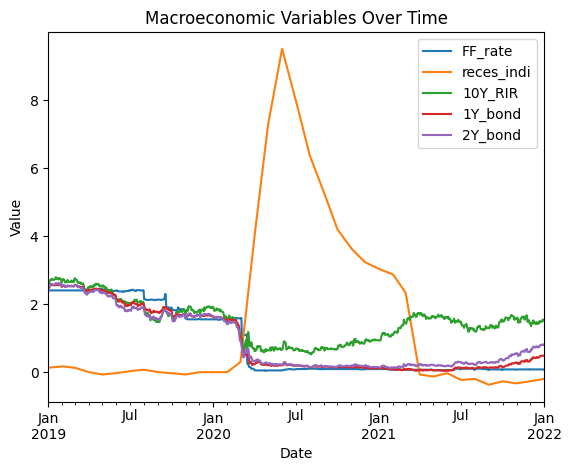

In [32]:

# Convert all columns to numeric if they are not already
merged_df = merged_df.apply(pd.to_numeric, errors='coerce')

# Set the DATE column as the index if it's not already
if 'DATE' in merged_df.columns:
    merged_df.set_index('DATE', inplace=True)

# Plot each column
for column in merged_df.columns:
    if column != 'gold_price':
        merged_df[column].plot(label=column)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Macroeconomic Variables Over Time')

# Show the legend and the plot
plt.legend()
plt.show()

In [15]:
data_macro_path_parq = Path.cwd().parent / "Data/Macroeconomic_variables/merged_marcofirm.parquet"

save_parquet = True
if save_parquet or not os.path.exists(data_macro_path_parq):
    merged_df.to_parquet(data_macro_path_parq)